#Environment Setup and Data Preprocessing
Import required libraries, set random seeds for reproducibility, and prepare the Flowers-102 dataset with specialized training augmentations and normalization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, models, transforms

import numpy as np
import random

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
dataset, dataset_info = tfds.load(
    "oxford_flowers102",
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.HBRPOI_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.HBRPOI_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.HBRPOI_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


#Data Augmentation and Transformation
Define random cropping, flipping, rotation, and color jittering for training, alongside standard normalization for validation and testing.

In [ ]:
IMAGE_SIZE = 224
NUM_CLASSES = 102

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


#Custom PyTorch Dataset Wrapper
Define a class to bridge TensorFlow datasets into a PyTorch-compatible format with support for on-the-fly transformations.

In [ ]:
class Flowers102Dataset(Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.tf_dataset = tf_dataset
        self.transform = transform
        self.length = tf_dataset.cardinality().numpy()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img, label = next(iter(self.tf_dataset.skip(idx).take(1)))

        img = img.numpy()
        label = int(label.numpy())

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_ds = datasets.Flowers102(
    root="./data",
    split="train",
    download=True,
    transform=train_transform
)

val_ds = datasets.Flowers102(
    root="./data",
    split="val",
    download=True,
    transform=eval_transform
)

test_ds = datasets.Flowers102(
    root="./data",
    split="test",
    download=True,
    transform=eval_transform
)


100%|██████████| 345M/345M [00:16<00:00, 20.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.24MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 42.9MB/s]


In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
imgs, labels = next(iter(train_loader))
print(imgs.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#Model Architecture and Selective Fine-Tuning
Load a pre-trained ResNet-50 backbone, replace the classifier head, and unfreeze layers 3 and 4 to adapt high-level features to the flower dataset.

In [ ]:
NUM_CLASSES = 102

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3 and layer4
for param in model.layer3.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

model = model.to(device)

#Loss Function and Optimizer
Define the Cross-Entropy loss criterion and initialize the Adam optimizer to update only the unfrozen parameters.

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

#Training and Evaluation Logic
Implement functions to handle the forward-backward pass for training and a separate utility to calculate accuracy on validation or test sets.

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    correct, total = 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return correct / total

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

#Model Training Execution
Run the training loop for a specified number of epochs while logging the progression of training, validation, and final test accuracy.

In [ ]:
EPOCHS = 7

for epoch in range(EPOCHS):
    train_acc = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

test_acc = evaluate(model, test_loader)
print("Test Accuracy:", test_acc)

Epoch [1/7] | Train Acc: 0.1480 | Val Acc: 0.3882
Epoch [2/7] | Train Acc: 0.5941 | Val Acc: 0.6618
Epoch [3/7] | Train Acc: 0.7824 | Val Acc: 0.7510
Epoch [4/7] | Train Acc: 0.8745 | Val Acc: 0.8284
Epoch [5/7] | Train Acc: 0.9461 | Val Acc: 0.8843
Epoch [6/7] | Train Acc: 0.9755 | Val Acc: 0.9049
Epoch [7/7] | Train Acc: 0.9882 | Val Acc: 0.9137
Test Accuracy: 0.8812815091884859


In [ ]:
test_acc = evaluate(model, test_loader)
print("Test Accuracy:", test_acc)

#Model Persistence
Save the state dictionary of the fine-tuned model to a file for later use in deployment or ensembling.

In [ ]:
MODEL_PATH = "/content/level2_resnet50_aug_new_with_layer_3.pth"
torch.save(model.state_dict(), MODEL_PATH)

print("Model saved to:", MODEL_PATH)

Model saved to: /content/level2_resnet50_aug_new_with_layer_3.pth


#Inference Visualization
Execute a prediction pass on a random test image and visualize the results alongside the ground truth and confidence score.

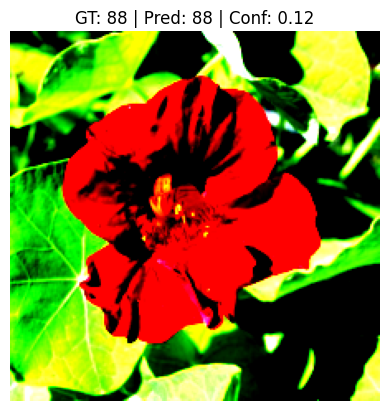

In [ ]:
import random

model.eval()
idx = random.randint(0, len(test_ds) - 1)
img, label = test_ds[idx]

with torch.no_grad():
    output = model(img.unsqueeze(0).to(device))
    prob = torch.softmax(output, dim=1)
    pred = torch.argmax(prob, dim=1).item()

plt.imshow(img.permute(1,2,0))
plt.title(f"GT: {label} | Pred: {pred} | Conf: {prob[0][pred]:.2f}")
plt.axis("off")
plt.show()